# Seurat: Xenium
conda env: single-cell_R-4.0.3

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

# Specific requirement for xenium: 
library(arrow) # -> Helps to read in .parquet file

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelev

In [ ]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/MM_noLQ_fUMAP_08-03-2024.rds")
pancancer_sc$MM_type <- factor(pancancer_sc$MM_type, levels = c("Classical Mono", 'Non-classical Mono', 'Mono-like Mac', 'Inflam Mac', 'IFN Mac', 
                                                        'Interm Mac', 'Mono-like LAM', "LAM1", 'Hypoxic Mac', 'Perivasc Mac', 'MT Mac', "LAM2", 'Immunosuppr Mac',
                                                        "Proliferating Macro", "Neutrophils"))

# Create spatial object (V5->V4)
obj_v5 <- readRDS(paste0(dir, "/xenium5k_obj_MM.rds"))
obj <- CreateSeuratObject(counts = obj_v5[['Xenium']]@counts, meta.data = obj_v5@meta.data, assay = "Xenium")

In [4]:
pancancer_sc$MM_type %>% unique()

[1] LAM1                Inflam Mac          Interm Mac         
 [4] Mono-like Mac       Classical Mono      Non-classical Mono 
 [7] Perivasc Mac        Proliferating Macro MT Mac             
[10] Hypoxic Mac         Immunosuppr Mac     Mono-like LAM      
[13] LAM2                IFN Mac             Neutrophils        
15 Levels: Classical Mono Non-classical Mono Mono-like Mac ... Neutrophils

[1] "Summary of uniqueRNA"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   181.0   283.0   347.7   472.0  1581.0 
[1] "Summary of counts"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  106.0   222.0   378.0   553.3   740.0  5372.0 


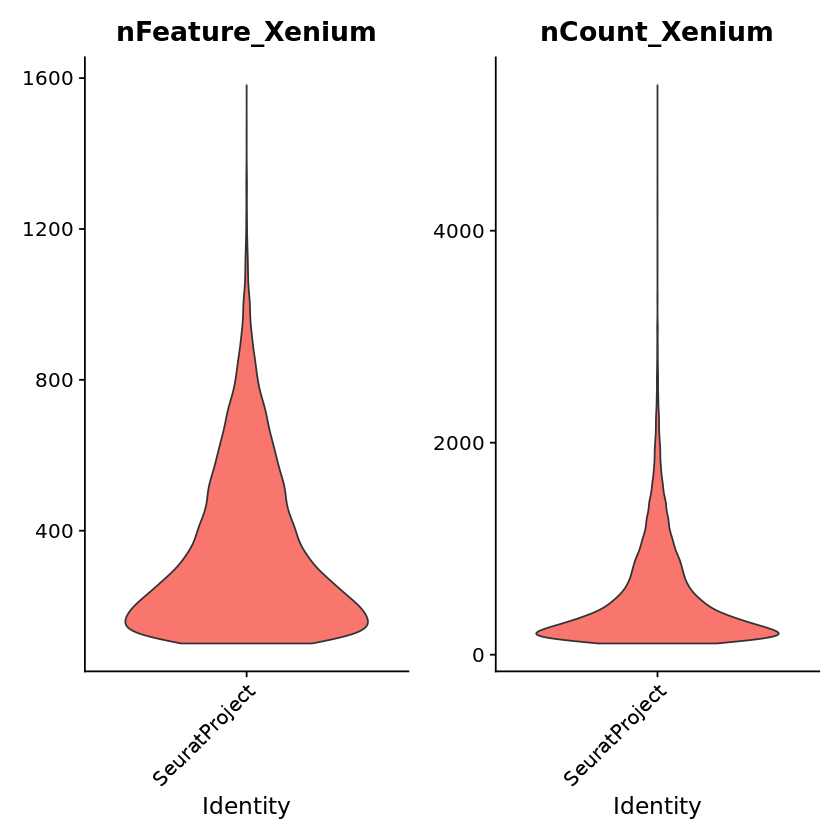

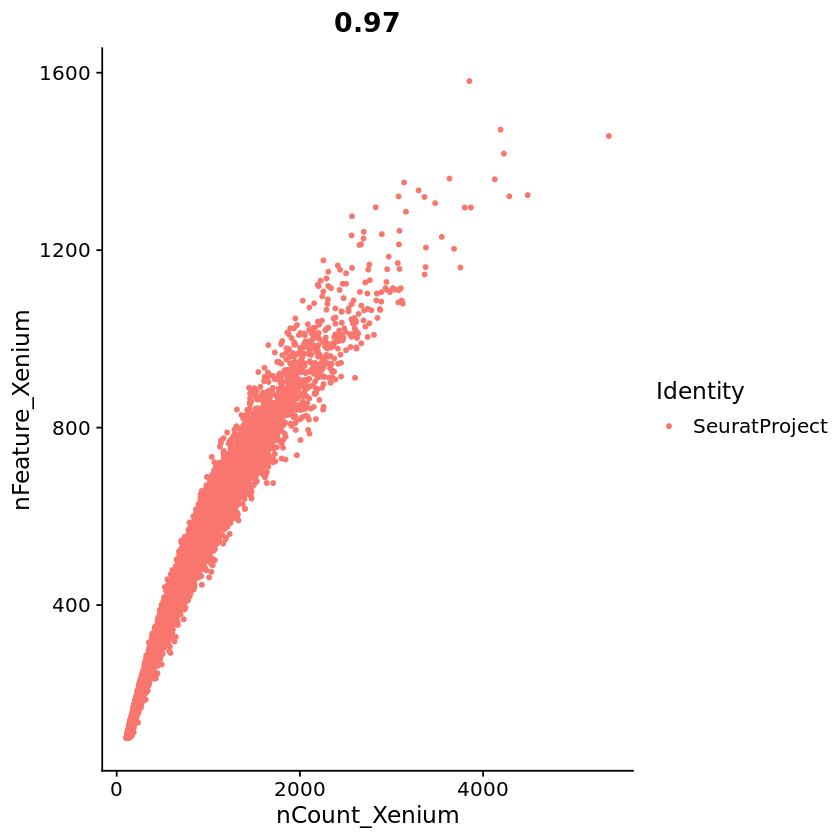

In [5]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

Idents(obj) <- "SeuratProject"
VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [6]:
# Clean everything in case we did the PCA analysis before
obj <- DietSeurat(obj, dimreducs = "spatial")

# Normalize data and calculate cell cycle scores
obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [7]:
# Perform cluster analysis
obj <- FindVariableFeatures(obj, nfeatures = 2000) %>%
        ScaleData(do.scale=TRUE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
        RunPCA(npcs=30) %>%
        RunUMAP(dims = 1:30, min.dist=0.05) %>%
        FindNeighbors(reduction = "pca", dims = 1:30) %>%
        FindClusters(resolution = c(0.1, 0.2, 0.3, 0.5, 0.8))

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  SLC40A1, F13A1, STAB1, EPCAM, NBL1, CXCR4, LTBP2, LPCAT1, GAS6, LBH 
	   LAPTM4B, PLS3, CTTN, CDH1, OLFML3, CXCL12, SPTBN1, IL6ST, PFKFB3, NKX2-1 
	   DDR1, MUC1, CTLA4, TSPAN13, CLPTM1L, MYH10, ITPR3, EPDR1, CD3E, HHLA2 
Negative:  MARCO, INHBA, FBP1, TREM1, LPL, CYP27A1, GLIPR2, CTSL, OLR1, PLAUR 
	   ANPEP, LTA4H, EGR2, IL1RN, ABCG1, C8B, PLIN2, GLDN, IGFBP2, RETN 
	   CD83, ACP5, KCNA3, PNPLA6, FPR2, HBEGF, MX1, ALDH2, IFIT3, VSIG4 
PC_ 2 
Positive:  EPCAM, CDH1, HHLA2, FBP1, MARCO, LAPTM4B, TREM1, MACC1, TMPRSS2, MUC1 
	   MX1, CP, LDHA, FOLR1, VSTM2L, NKX2-1, AGR3, IFIT3, OLR1, CLPTM1L 
	   LTA4H, HPGD, INHBA, ALDH2, HOPX, CTTN, TSPAN13, EPDR1, CYP27A1, GLIPR2 
Negative:  F13A1, STAB1, CD14, NBL1, FOLR2, CXCL12, LGMN, CXCR4, SLC40A1, LTBP2 
	   LILRB5, LBH, PFKFB3, GAS6, CD3E, TCF21, PDE5A, MYH10, DPT, CCDC80 
	   VCAM1, CCL13, INMT, SMAP2, IL2RA, MAF, CCL19, ADAMTS1, MYLK, MZB1 
PC_ 3 
Positi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18459
Number of edges: 624478

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9324
Number of communities: 5
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18459
Number of edges: 624478

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9087
Number of communities: 8
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18459
Number of edges: 624478

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8877
Number of communities: 10
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18459
Number of edges: 624478

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8594
Number of communities: 14
Elapsed time: 3 seconds
Modularity Opt

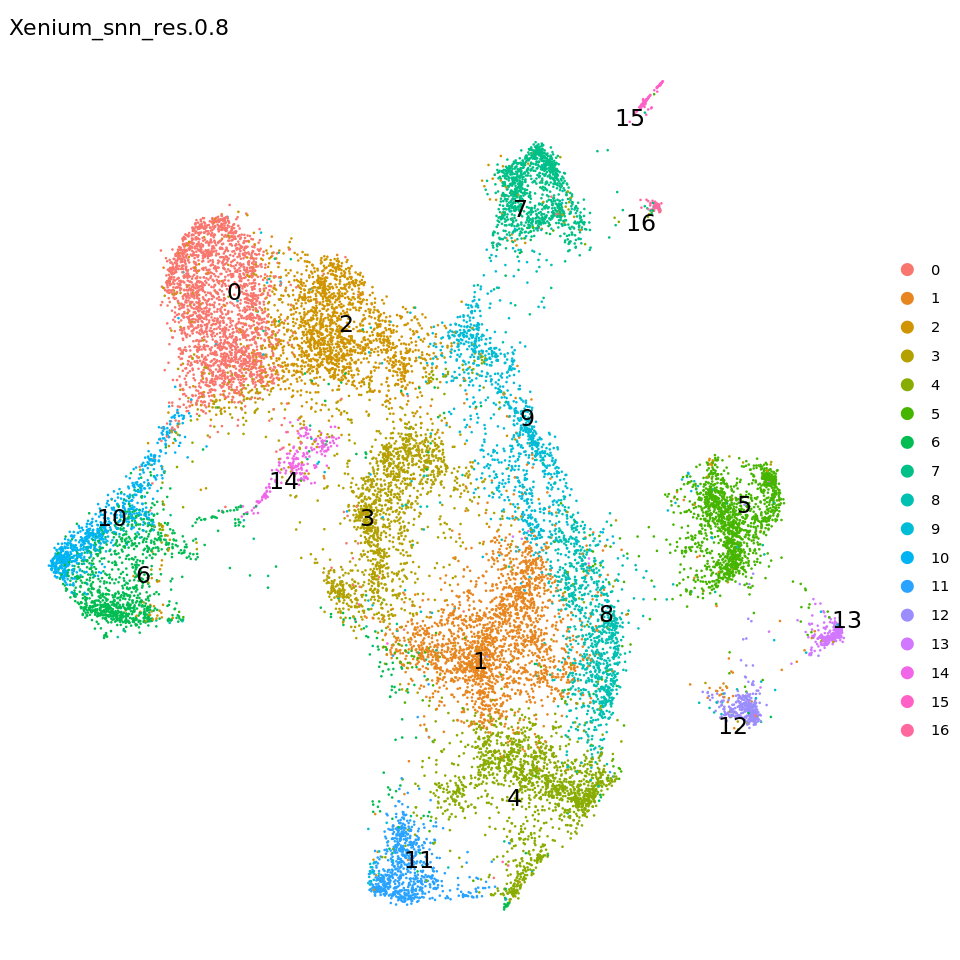

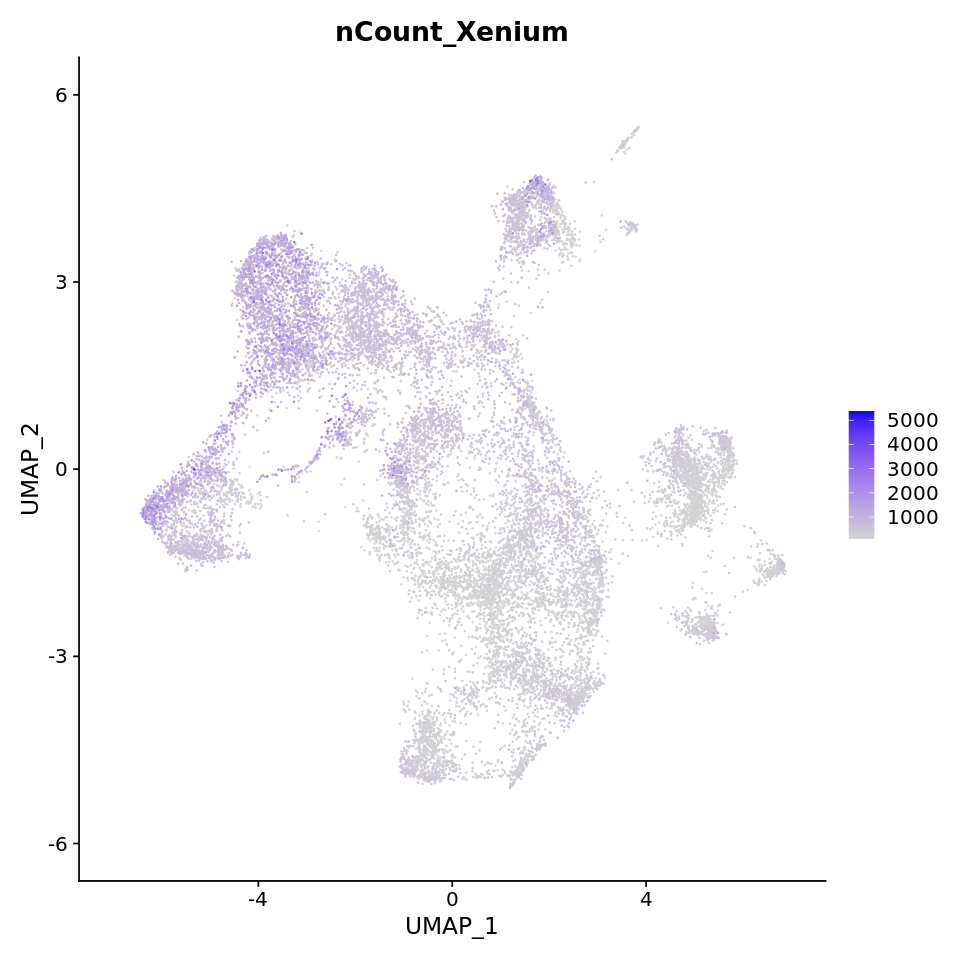

In [8]:
figsize(8, 8)
DimPlot(obj, group.by = "Xenium_snn_res.0.8", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()# + NoLegend()
FeaturePlot(obj, features = "nCount_Xenium")

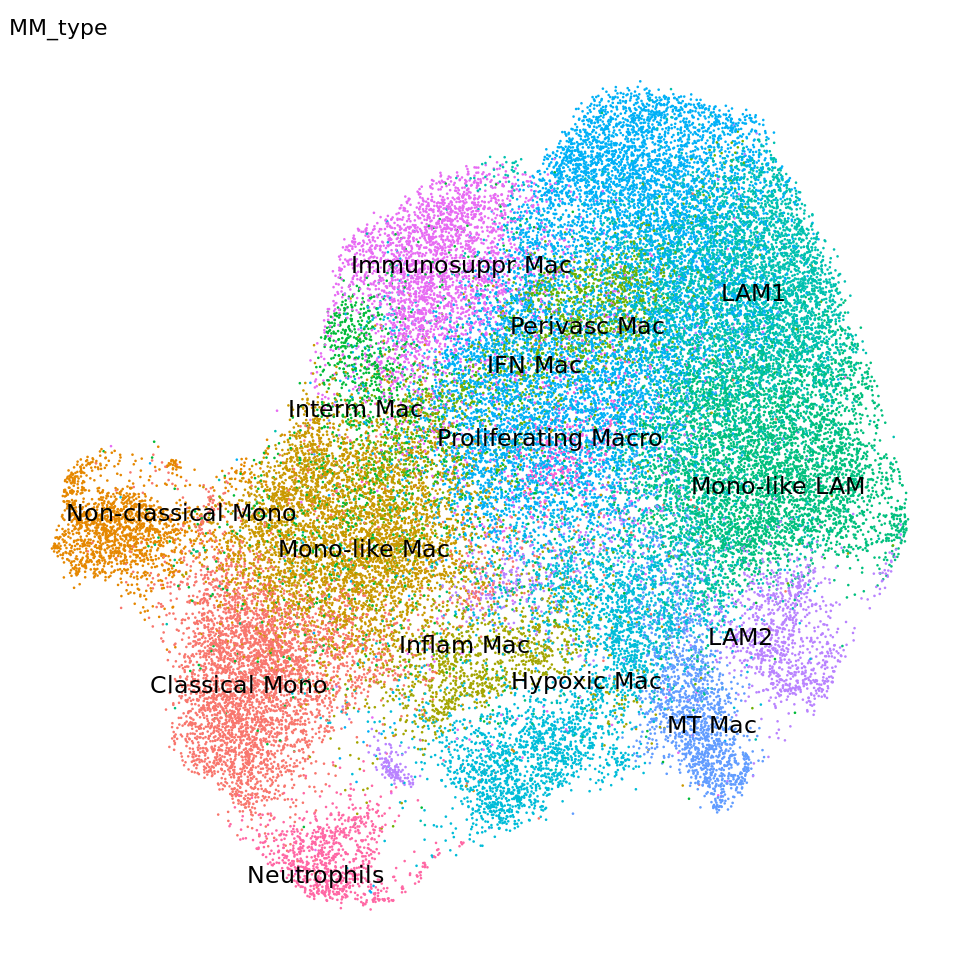

In [9]:
# Subtype annotation in reference dataset (PanCancer atlas)
figsize(8, 8)
DimPlot(pancancer_sc, group.by = "MM_type", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()+ NoLegend()

## Seurat Integration

In [10]:
# Clean the spatial data
DefaultAssay(obj) <- "Xenium"
obj$Batch <- "Xenium"
pancancer_sc$Batch <- "Single-cell"

In [11]:
# Get the common genes between the two datasets
common_genes <- rownames(obj)[rownames(obj) %in% rownames(pancancer_sc)]
pancancer_sc <- pancancer_sc[common_genes, ]

In [12]:
# Create query subset
obj.query <- obj
obj.query <- obj.query[common_genes, ]

# Create reference dataset
obj.ref <- pancancer_sc
obj.ref$MM_type <- factor(obj.ref$MM_type)

In [13]:
obj.ref
obj.query

An object of class Seurat 
5001 features across 46150 samples within 1 assay 
Active assay: RNA (5001 features, 619 variable features)
 4 dimensional reductions calculated: pca, umap, tsne, harmony

An object of class Seurat 
5001 features across 18459 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [14]:
options(future.globals.maxSize= 6000*1024^2)

obj.query <- NormalizeData(obj.query)
obj.anchors <- FindTransferAnchors(reference = obj.ref,
                                        query = obj.query,
                                        dims = 1:30,
                                        reference.reduction = "pca")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 22588 anchors

Filtering anchors

	Retained 5298 anchors



In [15]:
predictions <- TransferData(anchorset = obj.anchors, refdata = obj.ref$MM_type, dims = 1:30)
obj.query <- AddMetaData(obj.query, metadata = predictions)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [16]:
options(scipen = 999)
round(100*prop.table(table(obj.query$predicted.id)), 2)
round(100*prop.table(table(obj.ref$MM_type)), 2)


     Classical Mono         Hypoxic Mac             IFN Mac     Immunosuppr Mac 
               4.92                3.74                8.32                6.30 
         Inflam Mac          Interm Mac                LAM1                LAM2 
               0.09                0.06                3.72                5.81 
      Mono-like LAM       Mono-like Mac              MT Mac         Neutrophils 
              17.77                3.38                0.03                0.65 
 Non-classical Mono        Perivasc Mac Proliferating Macro 
               1.19               41.30                2.73 


     Classical Mono  Non-classical Mono       Mono-like Mac          Inflam Mac 
               9.44                3.48                9.95                2.45 
            IFN Mac          Interm Mac       Mono-like LAM                LAM1 
               3.98                3.16               10.97               11.55 
        Hypoxic Mac        Perivasc Mac              MT Mac                LAM2 
               7.93               20.46                3.58                3.42 
    Immunosuppr Mac Proliferating Macro         Neutrophils 
               7.06                0.71                1.85 

In [17]:
obj.ref <- RunUMAP(obj.ref, dims = 1:30, reduction = "pca", return.model = TRUE)
obj.query <- MapQuery(anchorset = obj.anchors, reference = obj.ref, query = obj.query,
    refdata = list(celltype = "MM_type"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

16:52:31 UMAP embedding parameters a = 0.9922 b = 1.112

16:52:31 Read 46150 rows and found 30 numeric columns

16:52:31 Using Annoy for neighbor search, n_neighbors = 30

16:52:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:52:36 Writing NN index file to temp file /tmp/RtmpG00jvp/file2bc94161947e11

16:52:36 Searching Annoy index using 1 thread, search_k = 3000

16:52:58 Annoy recall = 100%

16:52:58 Commencing smooth kNN distance calibration using 1 thread

16:53:00 Initializing from normalized Laplacian + noise

16:53:01 Commencing optimization for 200 epochs, with 2048768 positive edges



16:53:30 Optimization finished

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to refpca_”
Computing nearest neighbors

Running UMAP projection

16:53:48 Read 18459 rows and found  numeric columns

16:53:48 Processing block 1 of 1

16:53:48 Commencing smooth kNN distance calibration using 1 thread

16:53:48 Initializing by weighted average of neighbor coordinates using 1 thread

16:53:48 Commencing optimization for 67 epochs, with 369180 positive edges

16:53:51 Finished

Warn

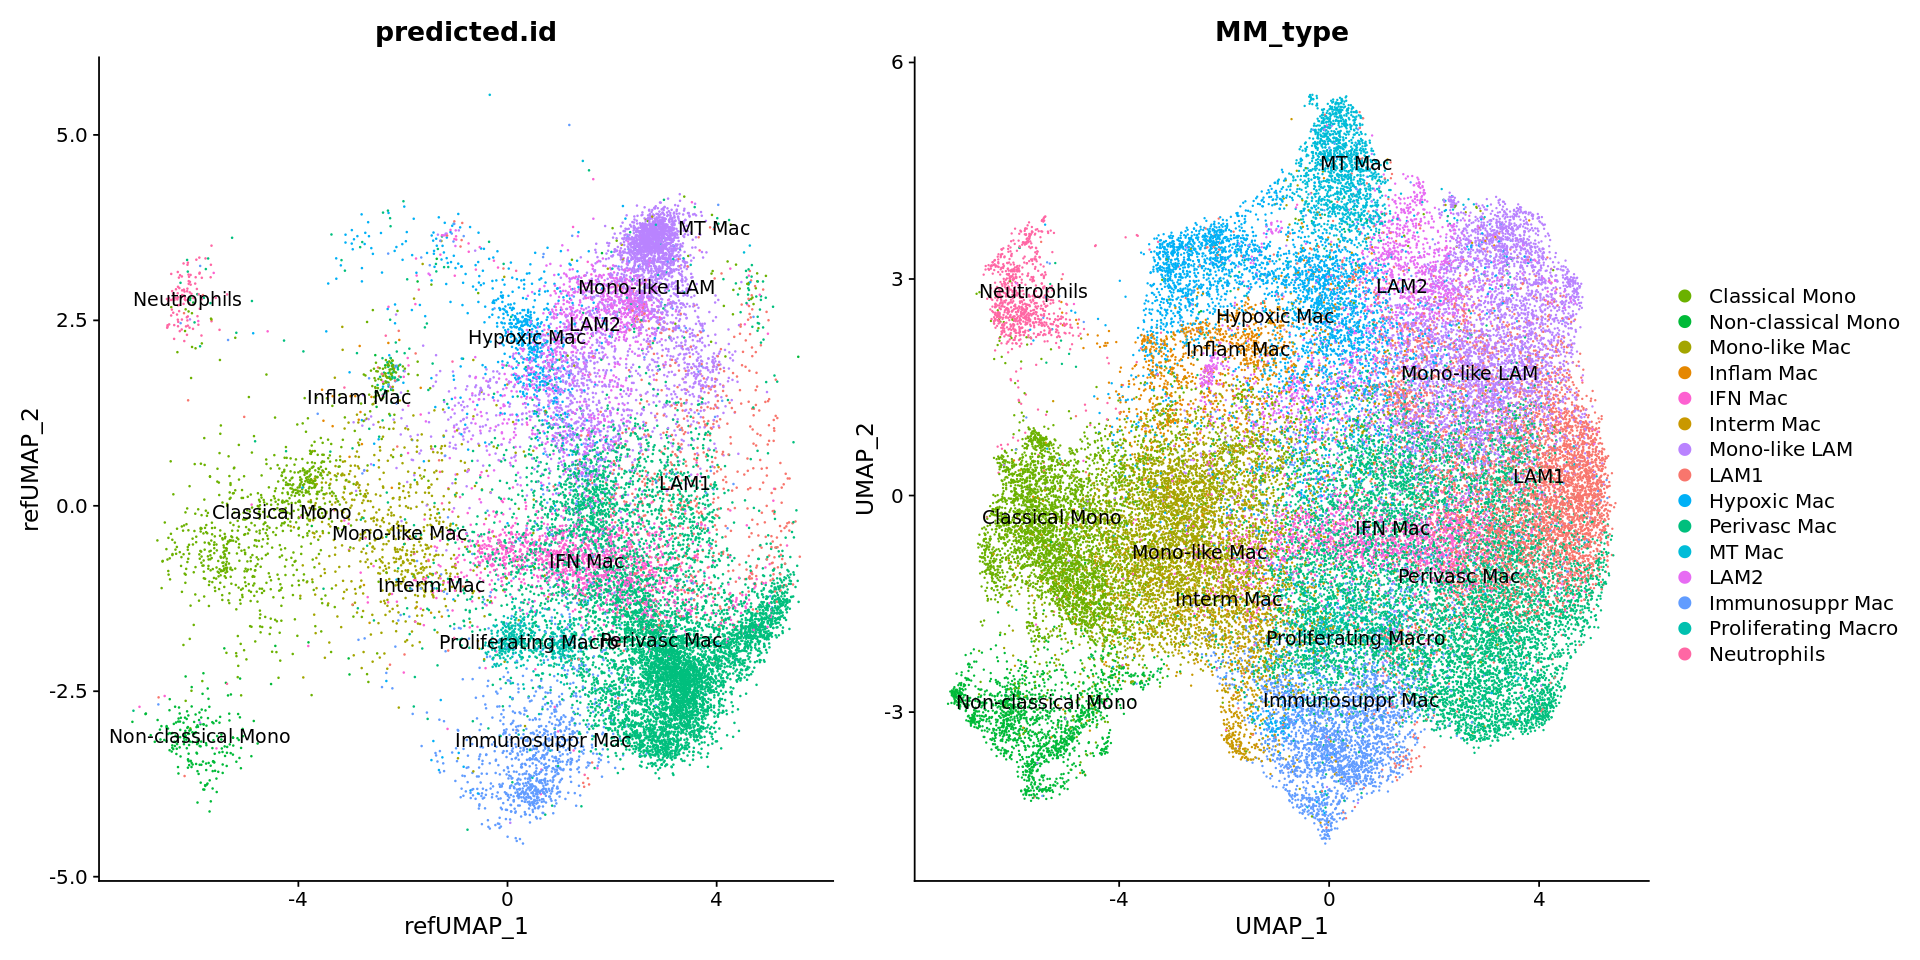

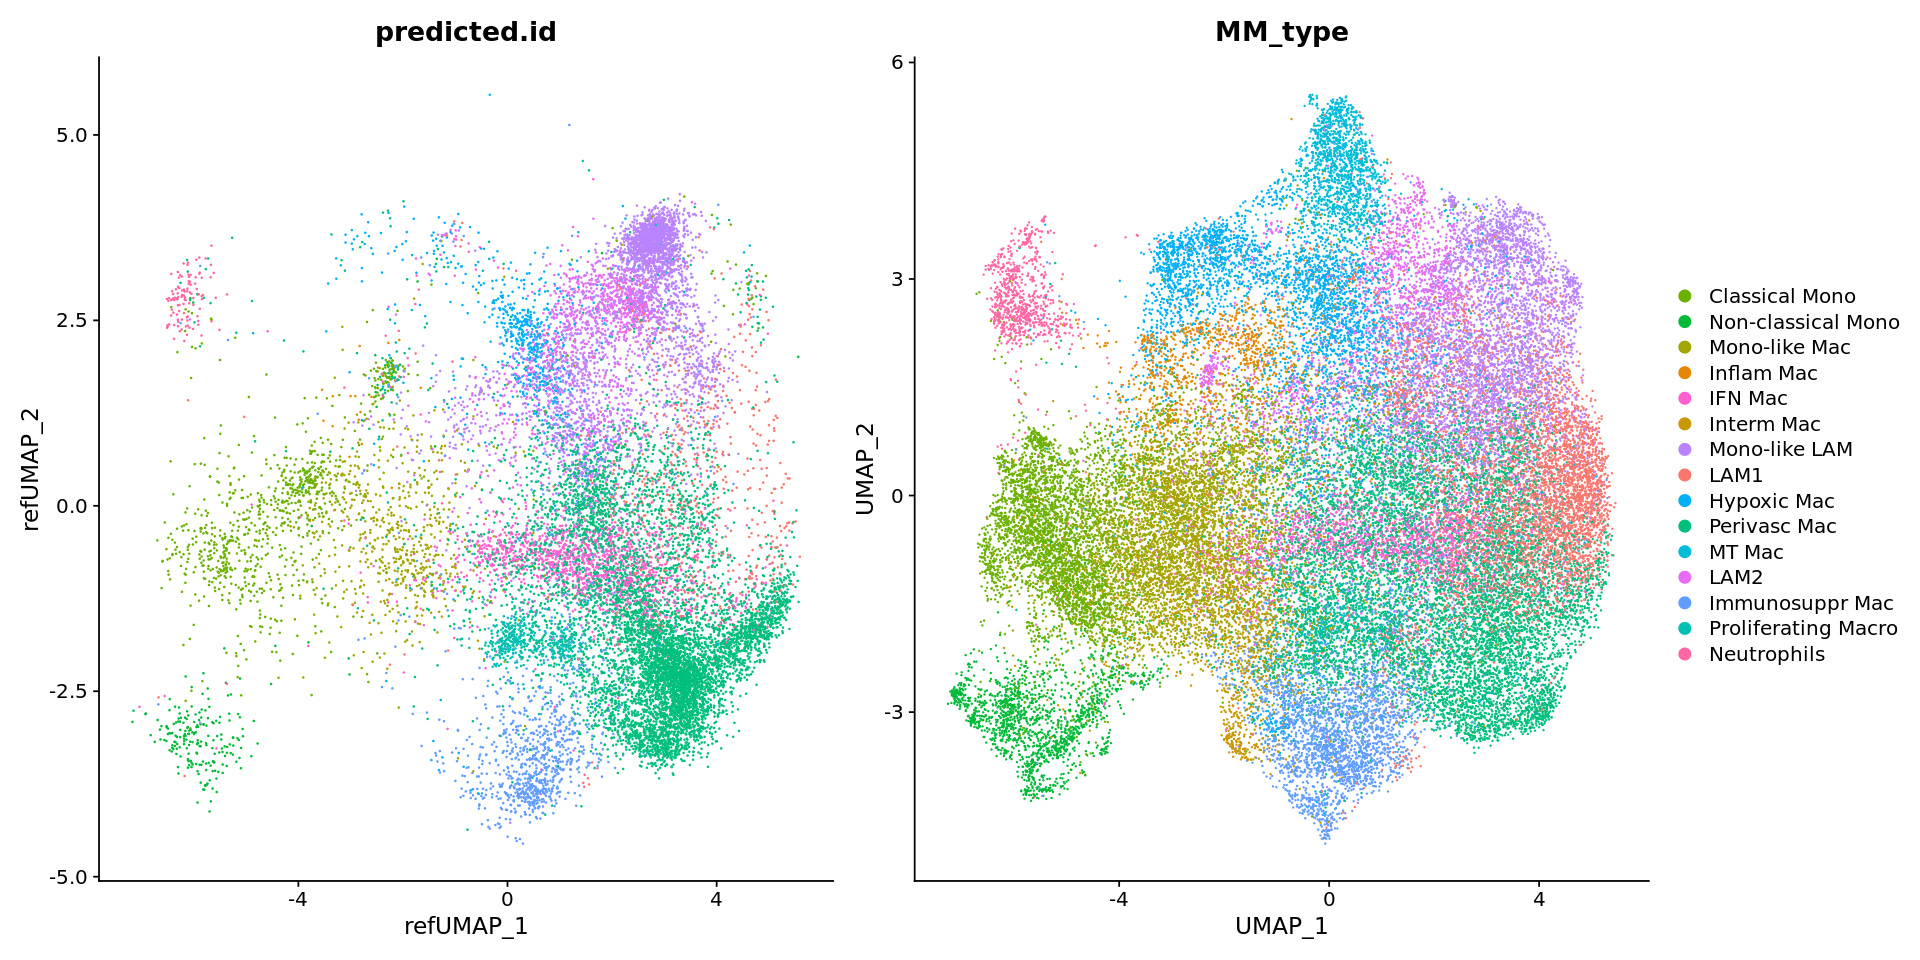

In [18]:
dd.col <- hue_pal()(length(unique(pancancer_sc$MM_type)))
names(dd.col) <- unique(pancancer_sc$MM_type)

figsize(16, 8)
(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id", label=TRUE) + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="MM_type", label=TRUE, repel = TRUE) & 
    scale_color_manual(values = dd.col) 

(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id") + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="MM_type") & 
    scale_color_manual(values = dd.col)

In [19]:
saveRDS(obj.query, file.path(dir, "MM_query.rds"))
saveRDS(obj.ref, file.path(dir, "MM_ref.rds"))

## Validate annotation - heatmap

In [27]:
obj.query <- readRDS(file.path(dir, "MM_query.rds"))
obj.ref <- readRDS(file.path(dir, "MM_ref.rds"))

In [38]:
markers <- FindAllMarkers(obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.5)
write.csv(markers, file = paste0(dir, "/Heesoo_results/FindAllMarkers_immune.csv"), row.names = FALSE)

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20



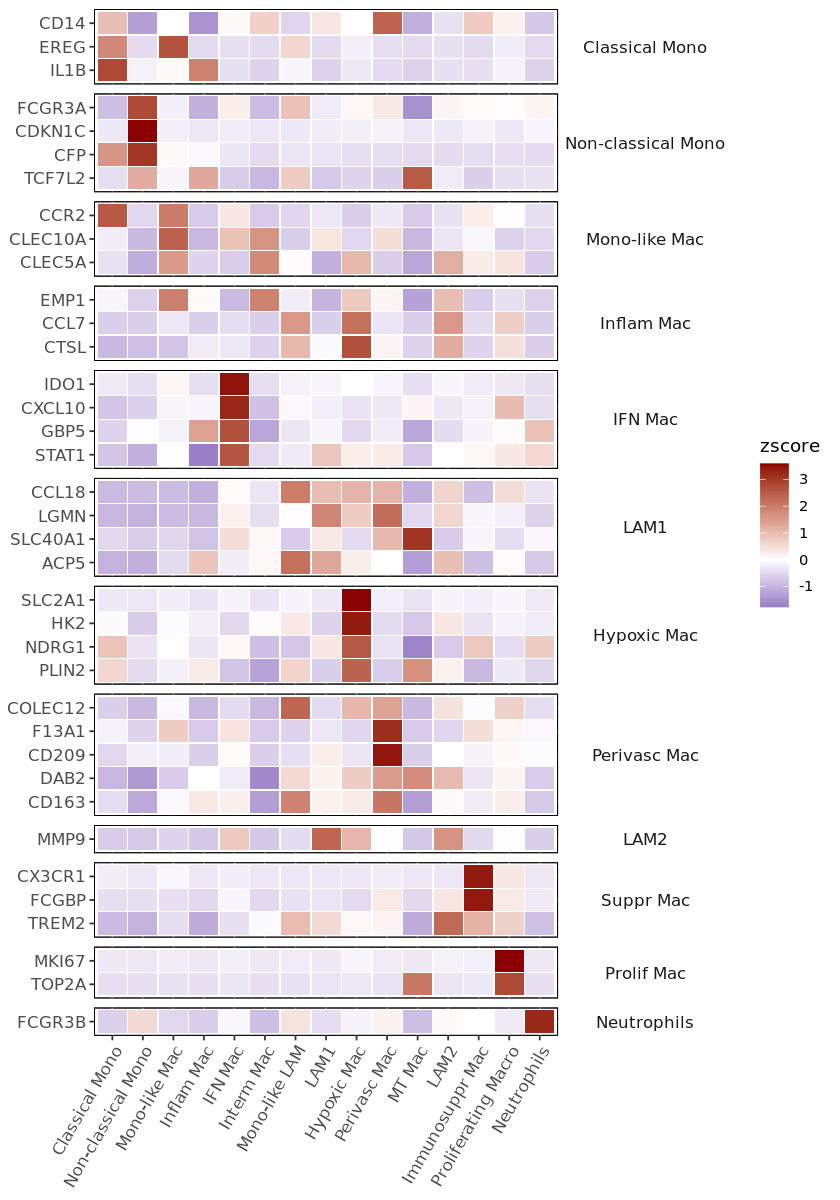

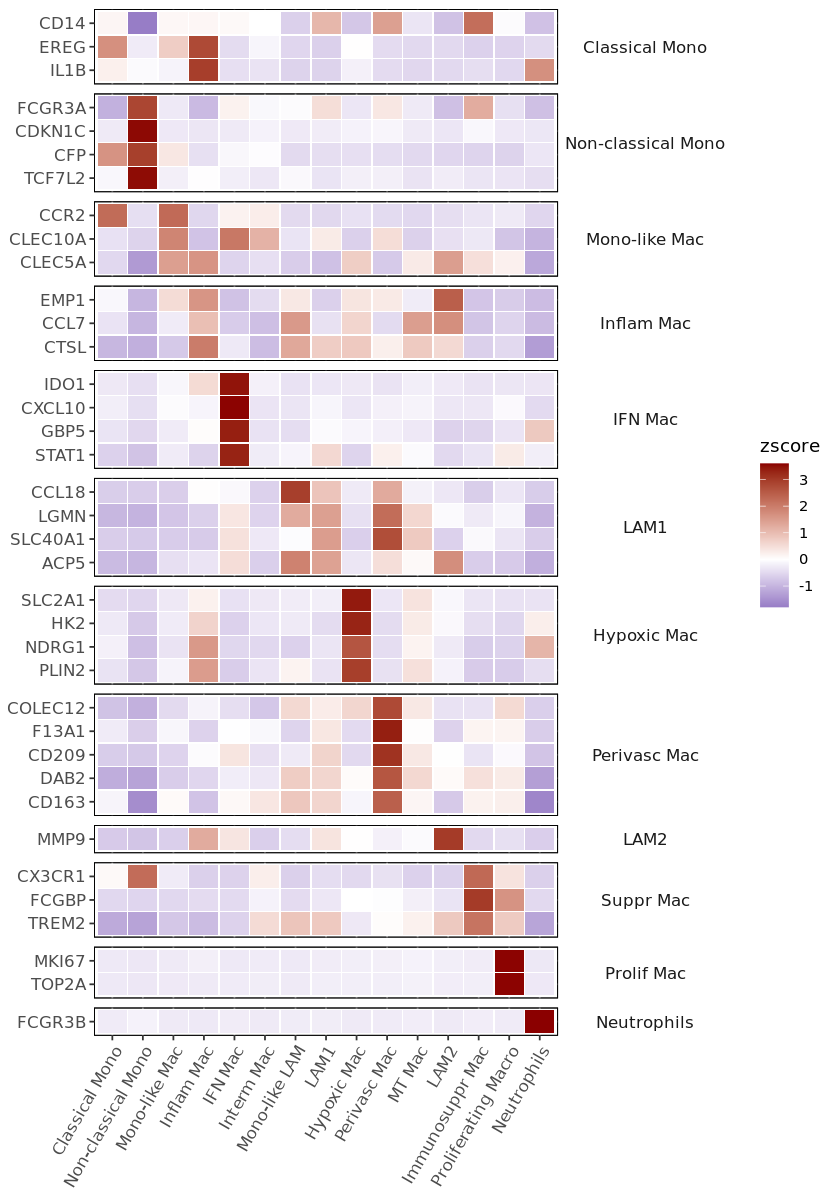

In [28]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")
MM_marker_genes_list <- list(`Classical Mono` = c("CD14", "S100A9", "S100A12", "EREG", "VCAN", "IL1B"),
                            `Non-classical Mono` = c("FCGR3A", "CDKN1C", "MTSS1", "LYPD2", "CFP", "TCF7L2"),
                            `Mono-like Mac` = c("CCR2", "CLEC10A", "PPA1", "GPR183", "CLEC5A", "ANKRD22", "FN1"),
                            `Inflam Mac` = c("CCL2", "ANKRD28", "EMP1", "MMP19", "CCL7", "SPP1", "CTSL"),
                            `IFN Mac` = c("IDO1", "CXCL10", "GBP5", "STAT1", "IL4I1"),
                            LAM1 = c("CCL18", "GPNMB", "NUPR1", "LGMN", "SLC40A1", "ACP5", "IFI27"),
                            # `Interm Mac` = c(),
                            # `Mono-like LAM` = c(),
                            `Hypoxic Mac` = c("SLC2A1", "HK2", "ERO1A", "NDRG1", "PLIN2"),
                            `Perivasc Mac` = c("LYVE1", "COLEC12", "F13A1", "CD209", "DAB2", "CD163", "SELENOP"),
                            `MT Mac` = c("MT1G", "MT1X", "MT1F", "MT1E", "MT1H"),
                            LAM2 = c("MMP9", "MMP7", "CA2", "TM4SF19"),
                            `Suppr Mac` = c("CX3CR1", "C3", "FCGBP", "PLD4", "HERPUD1", "TREM2"),
                            `Prolif Mac` = c("MKI67", "TOP2A"),
                            Neutrophils = c("FCGR3B", "G0S2", "CXCL8", "PROK2"))

figsize(7,10)
# obj.query$cluster_rename <- paste0("cluster_", obj.query$`Xenium_snn_res.0.5`)
# heatmap(obj.query, genes = MM_marker_genes_list, assay = "Xenium", group.by = "cluster_rename")
obj.query$predicted.id <- factor(obj.query$predicted.id, levels = levels(pancancer_sc$MM_type))
heatmap(obj.query, genes = MM_marker_genes_list, assay = "Xenium", group.by = "predicted.id")
heatmap(pancancer_sc, genes =  MM_marker_genes_list, assay = "RNA", group.by = "MM_type")